In [1]:
import torch
from torch import Tensor
import triton
import triton.language as tl

assert torch.cuda.is_available()
DEVICE = torch.device('cuda')
print(f"{DEVICE=}")

DEVICE=device(type='cuda')


In [75]:
def matvec(A: Tensor, x:Tensor) -> Tensor:
    # return torch.einsum('ij,j->i',A, x)
    return torch.matmul(A, x)

In [76]:
@triton.jit
def matvec_triton_kernel(A_pointer, x_pointer, y_pointer, A_row_stride, x_row_stride, y_row_stride, nrows, ncols, block_size: tl.constexpr):

    pid = tl.program_id(axis=0)
    step = tl.num_programs(axis=0)

    col_offset = tl.arange(0, block_size)
    mask = col_offset < ncols

    for row_idx in tl.range(pid, nrows, step):
        A_row_pointer = A_pointer + row_idx * A_row_stride
        A_col_pointer = A_row_pointer + col_offset

        x_row_pointer = x_pointer + col_offset

        a = tl.load(A_col_pointer, mask)
        x = tl.load(x_row_pointer, mask)

        y = tl.sum(a * x)
        y_row_pointer = y_pointer + row_idx

        tl.store(y_row_pointer, y)



def matvec_triton(A: Tensor, x:Tensor) -> Tensor:
    assert A.is_cuda and x.is_cuda
    assert A.ndim == 2 and x.ndim == 1

    nrows, ncols = A.shape
    block_size = triton.next_power_of_2(ncols)
    y = torch.empty_like(A[:,0])

    grid = nrows,

    matvec_triton_kernel[grid](A, x, y, A.stride(0), x.stride(0), y.stride(0), nrows, ncols, block_size)

    return y


In [77]:
A = torch.rand(400, 400).to(DEVICE)
x = torch.rand(400,).to(DEVICE)

assert torch.allclose(matvec(A, x), matvec_triton(A, x))

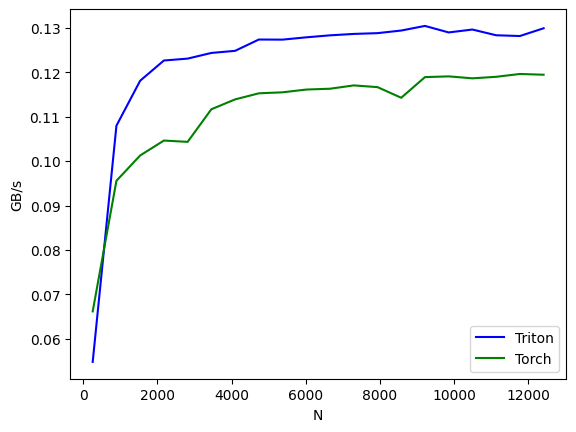

softmax-performance:
          N    Triton     Torch
0     256.0  0.054832  0.066195
1     896.0  0.107956  0.095567
2    1536.0  0.118074  0.101263
3    2176.0  0.122619  0.104617
4    2816.0  0.123045  0.104321
5    3456.0  0.124319  0.111655
6    4096.0  0.124792  0.113874
7    4736.0  0.127336  0.115239
8    5376.0  0.127313  0.115463
9    6016.0  0.127831  0.116086
10   6656.0  0.128280  0.116272
11   7296.0  0.128595  0.117020
12   7936.0  0.128772  0.116631
13   8576.0  0.129358  0.114240
14   9216.0  0.130396  0.118880
15   9856.0  0.128932  0.119051
16  10496.0  0.129584  0.118609
17  11136.0  0.128296  0.118952
18  11776.0  0.128124  0.119590
19  12416.0  0.129869  0.119422


In [79]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100, 5)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch',],  # possible values for `line_arg``
        line_names=["Triton", "Torch",],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    A = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    x = torch.randn(N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: matvec(A, x))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: matvec_triton(A, x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)